## Clustering : K-means /silhouette_score /  TSNE colored by GMM 
Later /!\ all Python code will be organized in the .src folder and imported here to  improve code readability across notebooks 

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("viridis")

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [2]:
PCA_INPUT_PATH = "/Users/essalehachraf/Desktop/Spotify-sHits-Unsupervised_Learning_Challenge/data /processed/playlist_2000to2022_pca_input.csv"
#  contains the log transformed, standard scaled data
df_model_scaled = pd.read_csv(PCA_INPUT_PATH)
X = df_model_scaled.copy()

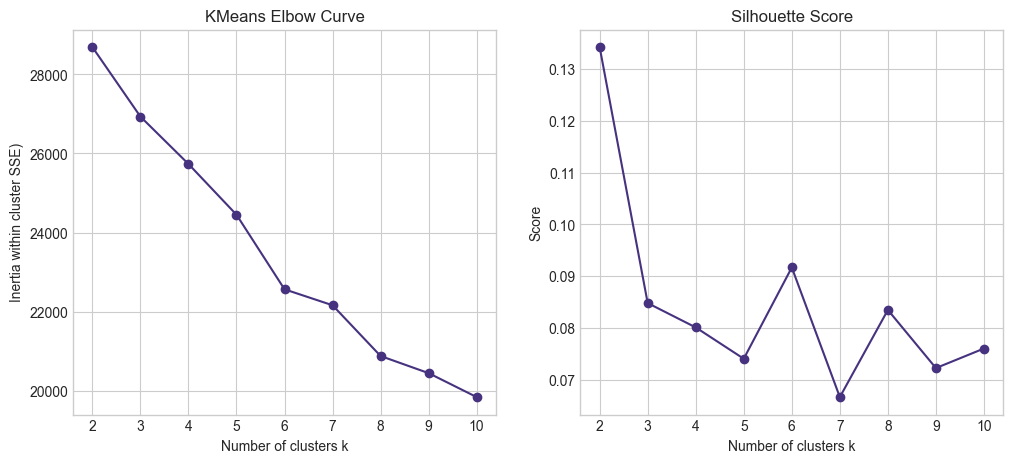

In [3]:
# we have to try several values of k to find an elbow / silhouette optimum
inertias = []
silhouettes = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42 , init="k-means++")
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X, kmeans.labels_))

# we plot both side by side 
fig, ax = plt.subplots(1, 2, figsize=(12,5))

ax[0].plot(K_range, inertias, marker='o')
ax[0].set_title("KMeans Elbow Curve")
ax[0].set_xlabel("Number of clusters k")
ax[0].set_ylabel("Inertia within cluster SSE)")
ax[0].grid(True)

ax[1].plot(K_range, silhouettes, marker='o')
ax[1].set_title("Silhouette Score")
ax[1].set_xlabel("Number of clusters k")
ax[1].set_ylabel("Score")
ax[1].grid(True)

plt.show()


- Left plot -> elbow curve 
We can see a drop in inertia between k=2 & k=6.
CC  : the elbow point is estimated to be between k=6 & k=7

- right plot -> silouhette score :
The silhouette is highest at k=2 & a sharp drop occurs for k=3 through k=5 we also see a slight rebound at k=6 
CC : low score across the range suggests that the clusters are relatively mixed in the PCA space -> low inherent cluster structure 

-> k=6 presents a good compromise between compactness (elbow) and separation (silhouette)

Cluster sizes:
cluster
0     34
1    652
2    422
3    296
4    578
5    317
Name: count, dtype: int64


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,track_popularity,artist_popularity
0,0.232005,0.042369,-0.165801,-0.806076,-0.380982,-0.394079,-0.073709,7.524309,-0.222698,-0.235136,0.100052,-0.092240,-0.201293,-0.547513
1,0.311274,0.337767,-0.186542,0.347178,0.819015,-0.363709,-0.297570,-0.126385,-0.053148,0.461422,-0.196078,-0.191983,0.064140,-0.054342
2,-1.121386,0.377347,-0.002805,0.271138,0.224419,-0.237162,-0.422636,-0.078508,0.130031,-0.712128,0.870297,0.298606,-0.135472,-0.133601
3,0.481351,-0.252553,0.016509,-0.297237,0.005774,2.092051,-0.010176,-0.148723,0.123232,0.147504,-0.064058,0.051476,-0.055974,0.105826
4,0.447296,0.282837,0.203808,0.331320,-1.220979,-0.196802,-0.212304,-0.112423,0.037856,0.426867,-0.225138,-0.151127,-0.038718,0.058698
5,-0.437322,-1.481481,0.018166,-1.315126,0.278448,-0.488569,1.579172,-0.098707,-0.223994,-0.891875,-0.295691,0.234737,0.192875,0.142505


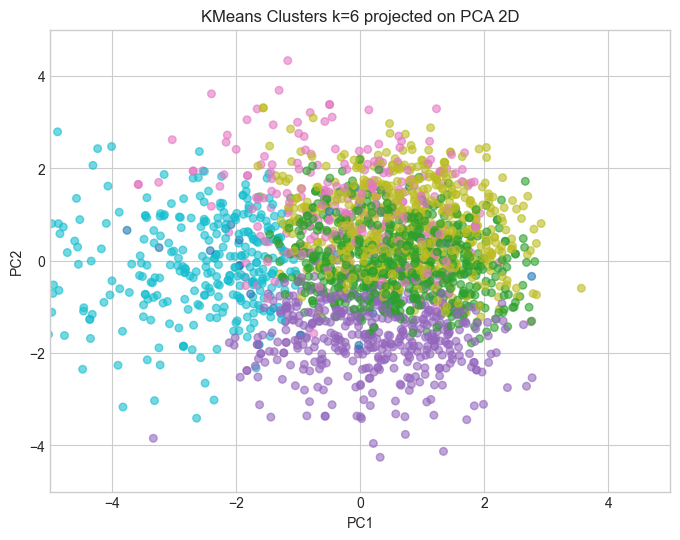

In [4]:
# Final KMeans with k=6 --> based on elbow and silhouette!!
kmeans_final = KMeans(n_clusters=6, random_state=42, init='k-means++')
df_model_scaled['cluster'] = kmeans_final.fit_predict(df_model_scaled)

# we inspect cluster sizes
print("Cluster sizes:")
print(df_model_scaled['cluster'].value_counts().sort_index())

# we compute the centroids
centroids = pd.DataFrame(kmeans_final.cluster_centers_, columns=df_model_scaled.columns[:-1])
display(centroids)

# we visualize PCA projection of clusters
pca_2d = PCA(n_components=2)
proj = pca_2d.fit_transform(df_model_scaled.drop(columns='cluster'))

plt.figure(figsize=(8,6))
plt.scatter(proj[:,0], proj[:,1], c=df_model_scaled['cluster'], cmap='tab10', alpha=0.6, s=30)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.title("KMeans Clusters k=6 projected on PCA 2D")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()



- we can observe  a **big overlap** between them, mostly centered around the center .
- We assume that the results are due to the fact that  PCA compresses the variance into 2 dimensions many cluster separations exist in higher dimensions wich means we're loosing info !!!! 
- we can use scores like ( **Silhouette Score**  seen in FML ) or (**Davies Bouldin Score** and **Calinski Harabasz Score** that some of the members have seen in their bachelor's degree in CS)

In [5]:
labels = kmeans_final.labels_
print("Silhouette Score:", silhouette_score(df_model_scaled.drop(columns='cluster'), labels))

Silhouette Score: 0.09167262749920649


- S Very low meaning  clusters are barely separated lots of overlap...

- even if we tried with different values of k the score still low 


In [6]:
df_meta=pd.read_csv("../data /processed/playlist_2000to2022_preprocessed_v2.csv")
df_clusters = pd.concat([df_meta.reset_index(drop=True), df_model_scaled['cluster']], axis=1)

# Check dominant genres in each cluster
top_genres_per_cluster = (
    df_clusters.groupby('cluster')['genre_grouped2']
    .value_counts(normalize=True)
    .groupby(level=0)
    .head(3)
)

print("Top 3 genres per cluster:")
print(top_genres_per_cluster)


Top 3 genres per cluster:
cluster  genre_grouped2
0        edm               0.323529
         pop               0.235294
         other             0.117647
1        pop               0.309816
         dance pop         0.260736
         hip hop           0.088957
2        pop               0.296209
         dance pop         0.158768
         modern rock       0.135071
3        hip hop           0.358108
         dance pop         0.202703
         pop               0.135135
4        dance pop         0.323529
         pop               0.268166
         hip hop           0.102076
5        pop               0.482650
         dance pop         0.135647
         other             0.078864
Name: proportion, dtype: float64


- We can see that majority of genres appearing everywhere ...
- we can assume that genre != audio features : different genres can often overlap in sound characteristics...


In [7]:
cluster_summary = df_model_scaled.groupby('cluster').mean()
display(cluster_summary)


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,track_popularity,artist_popularity
cluster,,,,,,,,,,,,,,
0,0.232005,0.042369,-0.165801,-0.806076,-0.380982,-0.394079,-0.073709,7.524309,-0.222698,-0.235136,0.100052,-0.092240,-0.201293,-0.547513
1,0.311274,0.337767,-0.186542,0.347178,0.819015,-0.363709,-0.297570,-0.126385,-0.053148,0.461422,-0.196078,-0.191983,0.064140,-0.054342
2,-1.121386,0.377347,-0.002805,0.271138,0.224419,-0.237162,-0.422636,-0.078508,0.130031,-0.712128,0.870297,0.298606,-0.135472,-0.133601
3,0.481351,-0.252553,0.016509,-0.297237,0.005774,2.092051,-0.010176,-0.148723,0.123232,0.147504,-0.064058,0.051476,-0.055974,0.105826
4,0.447296,0.282837,0.203808,0.331320,-1.220979,-0.196802,-0.212304,-0.112423,0.037856,0.426867,-0.225138,-0.151127,-0.038718,0.058698
5,-0.437322,-1.481481,0.018166,-1.315126,0.278448,-0.488569,1.579172,-0.098707,-0.223994,-0.891875,-0.295691,0.234737,0.192875,0.142505


- We compute the mean value of every feature for each cluster in orther to analyse how a typical song in a group looks like..

## EXTRA technique not seen in FML 

- t-SNE provides a nonlinear projection  that can reveal hidden structure not visible in PCA, most of members of our groupe have already used it ( some in pronto course last year and others during their Bachelor's in CS)
- confirming that the dataset does not contain **sharply** distinct musical categories based on audio features alone


In [8]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# Fit GMM with 2 components (same idea as KMeans best result)
gmm = GaussianMixture(n_components=5, random_state=42, covariance_type='full')
gmm_labels = gmm.fit_predict(X)


silhouette_gmm = silhouette_score(X, gmm_labels)
print(f"GMM Silhouette Score: {silhouette_gmm:.3f}")


GMM Silhouette Score: -0.024


- Gaussian components overlap strongly ->  cluster boundaries are fuzzy...-> musical features evolve gradually rather than forming discrete categories

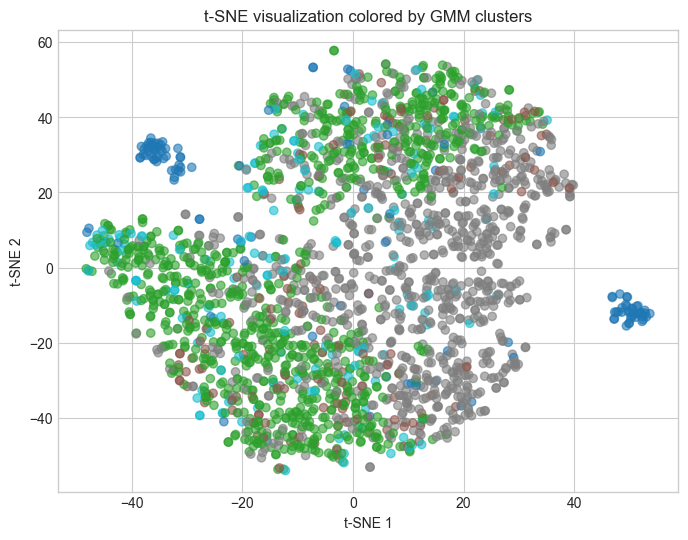

In [9]:
from sklearn.manifold import TSNE

# t-SNE projection to 2D for visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_proj = tsne.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(tsne_proj[:,0], tsne_proj[:,1], c=gmm_labels, cmap='tab10', alpha=0.6)
plt.title("t-SNE visualization colored by GMM clusters")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.show()


- we can see a few denser sub-regions appear on the edges( small, tight blue clusters on the left and right) 
- The overlapping central region shows that most songs share similar feature patterns : blending of popular genres like pop, dance-pop,hip-hop...
- combining GMM with t-SNE provided a more nuanced and realistic view of the dataset than K-Means — capturing both continuity and localized densities


In [10]:
# Save cluster labels
clusters = pd.DataFrame({"cluster": kmeans_final.labels_})
clusters.to_csv("/Users/essalehachraf/Desktop/Spotify-sHits-Unsupervised_Learning_Challenge/data /processed/playlist_2000to2022_clusters_k6.csv", index=False)

print("Cluster labels saved as playlist_2000to2022_clusters_k6.csv")

Cluster labels saved as playlist_2000to2022_clusters_k6.csv
